In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

## 1. Thermal model

Firstly we draw the plan of the two-zone building :

![cube](./figures/01_plan.svg)

> Figure 1. Plan of the building with thermal exchanges represented

In [27]:
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
T_ext = 0       # °C
σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant


The dimensions and surface areas of the building are:
- $H=3 \: \mathrm{m}$ - height of the building;
- $L=10 \: \mathrm{m}$ - lengh of the building;
- $l= \frac{L}{2}$ - width of the building and lengh of each zone;
- $S_g= l \times H$   - surface area of the glass window;
- $S_c = S_i = 5 \times S_g$   - surface area of the 5 (concrete, insulation and plaster) walls.

In [28]:
H = 3               # m height of the building
L = 10              # m lengh of the building
l = L/2              # m width of the building
Sg = l*H         # m² surface of the glass wall
Sc = Si = Sp = 5 * Sg    # m² surface of concrete & insulation & plaster of the 5 walls

We decided to choose the construction elements as in Figure 2.

![cube](./figures/02_walls_window.svg)

> Figure 2. Architecture of the walls and the window

Plaster is the BA13 whose thermophysical properties were found on [this site](http://pigo.free.fr/_media/re-caracteristiques-thermiques.pdf).
Plaster resists to humidity and acts as a thermic insulation.

In [29]:
concrete = {'Conductivity': 1.400,
            'Density': 2300.0,
            'Specific heat': 880,
            'Thickness': 0.2,
            'Surface': Sc}

insulation = {'Conductivity': 0.027,
              'Density': 55.0,
              'Specific heat': 1210,
              'Thickness': 0.08,
              'Surface': Si}

plaster = {'Conductivity': 0.25,
           'Density': 825, 
           'Specific heat': 1008,
           'Thickness': 0.02,
           'Surface': Sp}

window = {'Conductivity': 1.4,
         'Density': 2500,
         'Specific heat': 1210,
         'Thickness': 0.04,
         'Surface': Sg}

wall = pd.DataFrame.from_dict({'Insulation': insulation,
                               'Concrete': concrete,
                               'Plaster': plaster,
                               'Window': window},
                              orient='index')
wall

,Conductivity,Density,Specific heat,Thickness,Surface
Insulation,0.027,55.0,1210,0.08,75.0
Concrete,1.400,2300.0,880,0.20,75.0
Plaster,0.250,825.0,1008,0.02,75.0
Window,1.400,2500.0,1210,0.04,15.0


Avec ces données, nous déterminons les conductances liées à :
- la Conduction : $G_{cd}= \frac{\lambda}{e}S $ , avec e l'épaisseur
- la Convection : $G_{cv}= hS $  



 

In [30]:
# conduction
G_cd = wall['Conductivity'] / wall['Thickness'] * wall['Surface']
# convection
Gw = h * wall['Surface'][0]     # wall
Gg = h * wall['Surface'][2]     # glass
# view factor wall-glass
Fwg = window['Surface'] / concrete['Surface']
# long wave radiation
Tm = 20 + 273   # K, mean temp for radiative exchange

GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['Concrete']
GLW12 = 4 * σ * Tm**3 * Fwg * wall['Surface']['Concrete']
GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Window']

GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2)
print(G_cd['Window'])

525.0


De plus, nous devons prendre en compte l'advection due à l'infiltration de l'air. Elle est de la forme : 
$$G_v = \rho_a c_a \dot{V}_a$$
où : 
- $\dot{V}_a$ est le débit volumétrique de l'air, m³/s;
- $c_a$ est la capacité calorifique spécifique de l'air, J/kg·K;
- $\rho_a$ est la masse volumique de l'air, kg/m³

Par ailleurs, le débit est fonction du TRH (taux de renouvellement horaire) de l'air, et du volume d'air dans la pièce $V_{a}$ : 
$$\dot{V}_a = \frac{\mathrm{TRH}}{3600} V_a$$

- $TRH = 1 /h$
- $V_{a}=Hl^2$



In [31]:
#air
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
# pd.DataFrame.from_dict(air, orient='index', columns=['air'])
pd.DataFrame(air, index=['Air'])
# ventilation flow rate
Va = H*(l**2)                 # m³, volume of air
TRH = 1                     # air changes per hour
Va_dot = TRH / 3600 * Va    # m³/s, air infiltration

# ventilation & advection
Gv = air['Density'] * air['Specific heat'] * Va_dot

Enfin, nous prenons en compte le rayonnement entre la vitre et les 3 murs + sol + plafond de la pièce 1, que nous allons désigner par l'indice "5w" (5 walls), de surface :    $$S_{5w}=3S_{g}+2 \times l^2 $$
Les conductances de l'échange radiatif sont de la forme : 
$$G_{g} = 4 \sigma \bar{T}^3 \frac{\varepsilon_{g}}{1 - \varepsilon_{g}} S_{g}$$

$$G_{g,5w} = 4 \sigma \bar{T}^3 F_{g,5w} S_{g} = 4 \sigma \bar{T}^3 F_{5w,g} S_{5w}$$

$$G_{5w} = 4 \sigma \bar{T}^3 \frac{\varepsilon_{w}}{1 - \varepsilon_{w}} S_{5w}$$

$\bar{T}$ désigne une température moyenne qui peut être approchée à 20°C : $\bar{T} = 20 °C$
$F_{g,5w}$ désigne le facteur de forme entre la vitre et les murs, définie par : $F_{g,5w} = \frac{S_{g}}{S_{5w}}$

Nous en déduisons la conductance radiative équivalente : $$G_{rad} = \frac{1}{1/G_{g} + 1/G_{g,5w} + 1/G_{5w}}$$

In [32]:
# 5 walls surface
S5w = 3*Sg+2*(l**2)

# view factor wall-glass
Fwg = Sg/S5w

# long wave radiation
Tm = 20 + 273   # K, mean temp for radiative exchange


GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * Sg
GLW12 = 4 * σ * Tm**3 * Fwg * S5w
GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * S5w

GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2)

Après les conductances, calculons les capacités, de la forme : $$ C_w= m_w c_w= \rho_w c_w e_w S_w    ,mur $$ 
$$C_a = m_a c_a = \rho_a c_a V_a , air$$

In [56]:
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Thickness']
C['Air'] = air['Density'] * air['Specific heat'] * Va
pd.DataFrame(C, columns=['Capacity'])
print(C['Air'])
print(C['Concrete'])

90000.0
30360000.0


Nous prendreons un controlleur proportionnel de gain $K_p = 1000$ , en effet une valeur élevée de celui-ci permet d'assurer la convergence vers la température souhaitée   $T_{i,sp}=20 °C$

In [34]:
Kp=1000
T_isp=20+273

Les flux de chaleur sont de 3 types : 
- solaire absorbé par les murs extérieurs : $\Phi_{o} = \alpha_{SW} S_w E_{tot}$ et $\Phi_a$ pour la vitre
- solaire absorbé par les murs intérieurs : $ \Phi_{i} = S E $
- flux internes (habitants, équipement électrique) : $\dot{Q}_a$

où $E$ et $E_{tot}$ désignent l'irradiance solaire reçue

Par simplification, nous considérerons $\Phi_{o}=\Phi_{i}=\Phi_a=\dot{Q}_a=1$

In [35]:
Phi_o=1
Phi_i=1
Phi_a=1
Q_a=1

Maintenant que nous avons l'architecture et les paramètres thermiques, un schéma électrique équivalent est réalisable

![cube](./figures/03_electric_scheme.svg)

Nous allons mettre en équation ce circuit, pour cela commençons par numéroter les noeuds et les branches du circuit : 
![cube](./figures/04.svg)




Nous avons besoin de la matrice incidente définie comme suit : 

$A_{kl} = \begin{cases}\phantom{-}
0 & \text{if branch } q_k \text{ is not connected to node }  \theta_l \\ 
+1 & \text{if branch } q_k \text{ enters into node }  \theta_l\\ 
-1 & \text{if branch } q_k \text{ gets out of node }  \theta_l 
\end{cases}$



In [36]:
A = np.zeros([27, 22])       
A[0, 0] = 1                 
A[1, 0], A[1, 1] = -1, 1   
A[2, 1], A[2, 2] = -1, 1  
A[3, 2], A[3, 3] = -1, 1  
A[4, 3], A[4, 4] = -1, 1   
A[5, 4], A[5, 5] = -1, 1
A[6, 5], A[6, 6] = -1, 1
A[7, 6], A[7, 7] = -1, 1
A[8, 7]=1
A[9, 7], A[9, 8] = -1, 1
A[10, 8], A[10, 9] = -1, 1
A[11, 10], A[11, 9] = -1, 1
A[12, 11], A[12, 10] = -1, 1
A[13, 12], A[13, 11] = -1, 1
A[14, 13], A[14, 12] = -1, 1
A[15, 14], A[15, 13] = -1, 1
A[16, 14]=1
A[17, 15], A[17, 12] = -1, 1
A[18, 15], A[18, 11] = -1, 1
A[19, 16], A[19, 15] = -1, 1
A[20, 17], A[20, 16] = -1, 1
A[21, 18], A[21, 17] = -1, 1
A[22, 19], A[22, 18] = -1, 1
A[23, 20], A[23, 19] = -1, 1
A[24, 21], A[24, 20] = -1, 1
A[25, 21]=1
A[26,11]=1



Nous codons aussi les matrices des conductances G, des capacités C, ainsi que les vecteurs de température b, et de flux f

In [58]:
G = np.diag(np.hstack(
    [Gw['out'], 2 * G_cd['Concrete'], 2 * G_cd['Concrete'], 2 * G_cd['Insulation'], 2 * G_cd['Insulation'],2 * G_cd['Plaster'],2 * G_cd['Plaster'],Gw['in'],Gv,Gw['in'],2*G_cd['Plaster'],2*G_cd['Plaster'],Gw['in'],Gg['in'],2*G_cd['Window'],2*G_cd['Window'],Gg['out'],GLW,Gw['in'],2*G_cd['Plaster'],2*G_cd['Plaster'],2*G_cd['Insulation'],2*G_cd['Insulation'],2*G_cd['Concrete'],2*G_cd['Concrete'],Gw['out'],Kp]))

C = np.diag([0,C['Concrete'],0,C['Insulation'],0,C['Plaster'],0,C['Air'],0,C['Plaster'],0,C['Air'],0,C['Window'],0,0,C['Plaster'],0,C['Insulation'],0,C['Concrete'],0])


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [61]:
b = np.zeros(27)        
b[[0,8,16,25,26]] = 1

f = np.zeros(22)        
f[[0, 11, 13, 15, 21]] = 1

Ces matrices et vecteurs vérifient le système d'équations différentielles   sur la température: 
$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$

Nous allons donner une représentation d'état de ce système : 
$$\left\{\begin{array}{rr}
\dot{\theta}_s=A_s \theta_s + B_s u\\ 
y = C_s \theta_s + D_s u
\end{array}\right.$$

y est la sortie du système d'équations, nous souhaitons accéder aux températures des deux pièces, alors : 
$$y = [\begin{matrix}
0  &0  &0  &0  &0  &0 &0  &\theta_7 &0 &0 &0 &\theta_{11} &0 ...
\end{matrix}]^T$$

In [65]:
y = np.zeros(22)         
y[[7,11]] = 1              
print(f'y = ', y)

[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)


y =  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Nous effectuons un test en régime permanent, dans ce cas :
- le controlleur proportionnel est désactivé : $K_p=0$
- les sources de chaleur sont nulles
- on considère $T_{i,sp}=20$ et   $T_{ext}=1$

In [66]:
f = np.zeros(22) 
b = np.zeros(27)        
b[[0,8,16,25]] = 1
b[26]=20

En régime permanent, $C \dot{\theta} = 0$ , le système se résout : 
$$\theta_{ss} = (A^T G A)^{-1}(A^T G b + f)$$

In [67]:
θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θ = {θ} °C')

θ = [ 1.14289465  1.39806367  1.65323268  6.94562709 12.2380215  12.38091615
 12.5238108  12.97035658 13.91566722 14.21816662 14.52066602 15.46597666
  9.9114231   6.43039845  2.9493738  14.40913529 14.24286272 14.07659014
  7.91834667  1.76010319  1.46318788  1.16627257] °C


Si nous utilisons la représentation d'état, nous pouvons extirper seules les températures qui nous intéressent.

In [68]:
bT = np.array([1, 1, 1, 1, 20])     
fQ = np.array([0, 0, 0, 0,0])         
u = np.hstack([bT, fQ])
print(f'u = {u}')

u = [ 1  1  1  1 20  0  0  0  0  0]


La sortie s'obtient par la relation : 
$$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$

In [69]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
print(f'yss = {yss} °C')

yss = [12.97035658 15.46597666] °C


Le programme fonctionne en régime permanent, testons pour finir la réponse dynamique. Les méthodes numériques utilisées sont Euler implicite et explicite.

In [72]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As

print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
dtmax = 2 * min(-1. / λ)
print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

# time step
dt = np.floor(dtmax / 60) * 60   # s
print(f'dt = {dt} s = {dt / 60:.0f} min')

# settling time
time_const = np.array([int(x) for x in sorted(-1 / λ)])
print('4 * Time constants: \n', 4 * time_const, 's \n')

t_settle = 4 * max(-1 / λ)
print(f'Settling time: \
{t_settle:.0f} s = \
{t_settle / 60:.1f} min = \
{t_settle / (3600):.2f} h = \
{t_settle / (3600 * 24):.2f} days')

# Step response
# -------------
# Find the next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
# pd.DataFrame(t, columns=['time'])

u = np.zeros([10, n])                # u = [To To To Tisp Φo Φi Qa Φa]
u[0:4, :] = 1 * np.ones([4, n])    # To = 10 for n time steps
u[4, :] = 20 * np.ones([1, n]) 
u[5:10, :] = 1 * np.ones([5, n])

# pd.DataFrame(u)

n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @\
        θ_exp[:, k] + dt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (θ_imp[:, k] + dt * Bs @ u[:, k])



Time constants: 
 [3.89875398e+01 9.31228162e+01 1.63648397e+03 1.75359405e+03
 2.79253015e+03 3.75793261e+03 4.83805196e+03 1.01456015e+04
 4.40278682e+04 4.38059806e+04] s 

2 x Time constants: 
 [7.79750795e+01 1.86245632e+02 3.27296793e+03 3.50718811e+03
 5.58506031e+03 7.51586521e+03 9.67610393e+03 2.02912030e+04
 8.80557365e+04 8.76119612e+04] s 

Maximum time step: 77.98 s = 1.30 min
dt = 60.0 s = 1 min
4 * Time constants: 
 [   152    372   6544   7012  11168  15028  19352  40580 175220 176108] s 

Settling time: 176111 s = 2935.2 min = 48.92 h = 2.04 days
Duration = 176400.0 s
Number of time steps = 2940


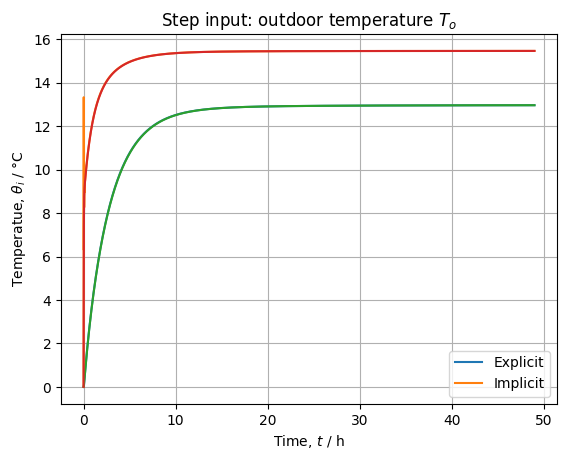

In [75]:
y_exp = Cs @ θ_exp + Ds @  u
y_imp = Cs @ θ_imp + Ds @  u

fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time, $t$ / h',
       ylabel='Temperatue, $θ_i$ / °C',
       title='Step input: outdoor temperature $T_o$')
ax.legend(['Explicit', 'Implicit'])
ax.grid()
plt.show()